In [82]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset,DataLoader
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from Models import *
from DDBSCAN import Raster_DBSCAN
import matplotlib.colors as mcolors
import cv2
from collections import defaultdict
import numpy as np
from scipy.interpolate import interp1d
import pandas as pd
# times new roman font
plt.rcParams["font.family"] = "Times New Roman"
seed = 414
# np.random.seed(seed)
colors = np.random.rand(600, 3)
colors = np.concatenate([np.array([[0,0,0]]),colors],axis = 0)
colormap = mcolors.ListedColormap(colors)

In [25]:
patience = 5 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 4
lane_unit = 200
time_span = 100
hidden_size = 256
num_layers = 2
input_size = lane_unit
learning_rate = 0.001
num_epochs = 50
best_model = BidirectionalLSTMLaneReconstructor(input_size, hidden_size, num_layers).to(device)
# best_model = UnidirectionalLSTMLaneReconstructor(input_size, hidden_size, num_layers).to(device)
# criterion = RangeWeightedBCELoss()
# criterion = FocalLoss()
# criterion = sigmoid_focal_loss(reduction='mean')
mocel_save_path = r"D:\TimeSpaceDiagramDataset\EncoderDecoder_EvenlySampled_FreeflowAug_0914_5res_lanechange_signal\models\train_2"
if not os.path.exists(mocel_save_path):
    os.makedirs(mocel_save_path)
model_name = f'checkpoint_6.pth'
best_model.load_state_dict(torch.load(os.path.join(mocel_save_path, model_name),weights_only=False))
best_model.eval()
db = Raster_DBSCAN(Td_map_szie=(lane_unit,time_span), window_size=[7,13],eps = 1,min_samples=3)

In [144]:
def get_traj_labels(traj_dir,trajectory,time_space_diagram):
    # read labels in txt file in keypoint format for yolov8 and extract the keypoint coordinates
    lines = []
    with open(os.path.join(traj_dir,trajectory),'r') as f:
        for line in f:
            line = line.strip().split()
            line = [float(i) for i in line]
            lines.append(line)
    lines = np.array(lines)
    trajs_label = []
    # from index 8 of each row is the keypoint coordinates: something, x,y , something, x,y ...
    for line in lines:
        coords = []
        for i in range(5,len(line),3):
            coords.append((line[i],line[i+1]))
        coords = np.array(coords)
        coords[:,0] *= time_space_diagram.shape[1]
        coords[:,1] *= time_space_diagram.shape[0]
        traj = coords[coords[:,0].argsort()]
        trajs_label.append(traj)
    return trajs_label


def get_trajctories_dict_from_Label_map(Labels,time_span):
    trajectories_output = defaultdict(list)
    for t in range(time_span):
        Labels_t = Labels[:,t]
        unique_id, xs, counts = np.unique(Labels_t,return_index=True,return_counts=True)
        center_locations = xs + counts / 2
        if unique_id[0] == -1:
            unique_id = unique_id[1:]
            center_locations = center_locations[1:]
        for i, label in enumerate(unique_id):
            trajectories_output[label].append((t,center_locations[i]))
    for key in trajectories_output.keys():
        traj = trajectories_output[key]
        trajectories_output[key] = np.array(traj)
    return trajectories_output

def get_trajs_from_LSTM_out(time_space_diagram,conf_thred = 0.35,time_span = 100, lane_unit = 200):
    pred_trajectories = time_space_diagram > conf_thred
    Labels = db.fit_predict(pred_trajectories, pred_trajectories)
    num_lane_units, time_span = time_space_diagram.shape
    trajectories_output = get_trajctories_dict_from_Label_map(Labels,time_span)

    return trajectories_output

# evaluate 
speed_eva_window = 5
def get_traj_errors(trajs_label,trajs_pred,speed_eva_window = 5):
    speed_errors = []
    location_errors = []
    for i, traj_label in enumerate(trajs_label):
        for j, traj_pred in enumerate(trajs_pred.values()):
            if len(traj_pred) < speed_eva_window:
                continue
            # Extract time and x values
            t_pred, x_pred = traj_pred[:, 0], traj_pred[:, 1]
            # drop duplicate time points
            t_pred, indices = np.unique(t_pred, return_index=True)
            x_pred = x_pred[indices]
            t_label, x_label = traj_label[:, 0], traj_label[:, 1]
            # drop duplicate time points
            t_pred, indices = np.unique(t_label, return_index=True)
            x_label = x_label[indices]
            # Interpolate label trajectory to match pred trajectory time points
            interp_func = interp1d(t_label, x_label, fill_value="extrapolate")
            x_label_interp = interp_func(t_pred)
            
            # get the overlapping time span
            t_label_max,t_label_min = t_label[-1],t_label[0]
            t_pred_max,t_pred_min = t_pred[-1],t_pred[0]
            # if two trajectories have overlapping time span

            if t_pred_max < t_label_min or t_pred_min > t_label_max:
                continue
            overlap_start = max(t_pred_min,t_label_min)
            overlap_end = min(t_pred_max,t_label_max)
            x_label_interp_overlap = x_label_interp[(t_pred >= overlap_start) & (t_pred <= overlap_end)]
            x_pred_overlap = x_pred[(t_pred >= overlap_start) & (t_pred <= overlap_end)]
            # Calculate residuals
            residuals = x_pred_overlap - x_label_interp_overlap
            if len(residuals) == 0:
                continue
            location_error = np.mean(np.abs(residuals)) * 0.5 # meters
            
            if location_error < 1: # they are the same trajectory
      
                location_errors.append(location_error)            

                # calculate speed error
                speed_pred_curve = []
                speed_label_curve = []
                for k in range(len(residuals)-speed_eva_window):
                    speed_pred = (x_pred_overlap[k+speed_eva_window] - x_pred_overlap[k])*0.5 / (speed_eva_window/10)
                    speed_label = (x_label_interp_overlap[k+speed_eva_window] - x_label_interp_overlap[k])*0.5 / (speed_eva_window/10)
                    speed_pred_curve.append(speed_pred)
                    speed_label_curve.append(speed_label)
                speed_pred_curve = np.array(speed_pred_curve)
                speed_label_curve = np.array(speed_label_curve)
                if len(speed_pred_curve) == 0:
                    continue
                speed_error = np.mean(np.abs(speed_pred_curve - speed_label_curve)) # m/s
                if speed_error > 4:
                    print(location_error,speed_error, i,j)
                    plt.plot(x_label_interp_overlap,'b')
                    plt.plot(x_pred_overlap,'r')
                    plt.show()
                speed_errors.append(speed_error)
    return location_errors, speed_errors

def get_TrajIoU(trajs_label,trajs_pred,x_error_threshold = 4):
    TrajIoUMatrix = np.zeros((len(trajs_label),len(trajs_pred)))
    TrajPortionMatrix = np.zeros((len(trajs_label),len(trajs_pred)))
    for i, traj_label in enumerate(trajs_label):
        for j, traj_pred in enumerate(trajs_pred.values()):
            # Extract time and x values
            t_pred, x_pred = traj_pred[:, 0], traj_pred[:, 1]
            # drop duplicate time points
            t_pred, indices = np.unique(t_pred, return_index=True)
            x_pred = x_pred[indices]
            t_label, x_label = traj_label[:, 0], traj_label[:, 1]
            # drop duplicate time points
            t_label, indices = np.unique(t_label, return_index=True)
            x_label = x_label[indices]
            # get the overlapping time span
            t_label_max,t_label_min = t_label[-1],t_label[0]
            t_pred_max,t_pred_min = t_pred[-1],t_pred[0]
            # if two trajectories have no overlapping time span, skip
            if t_pred_max < t_label_min or t_pred_min > t_label_max:
                continue
            # Interpolate label trajectory to match pred trajectory time points
            interp_func = interp1d(t_label, x_label, fill_value="extrapolate")
            t_label_interp = np.arange(int(t_label_min), int(t_label_max) + 1)
            x_label_interp = interp_func(t_label_interp)
            interp_func = interp1d(t_pred, x_pred, fill_value="extrapolate")
            t_pred_interp = np.arange(t_pred_min, t_pred_max + 1)
            x_pred_interp = interp_func(t_pred_interp)
            
            overlap_start = int(max(t_pred_interp.min(),t_label_interp.min()))
            overlap_end = int(min(t_pred_interp.max(),t_label_interp.max()))
            union_start = int(min(t_pred_interp.min(),t_label_interp.min()))
            union_end = int(max(t_pred_interp.max(),t_label_interp.max()))
            num_union = union_end - union_start + 1
            num_overlap = overlap_end - overlap_start + 1
            true_positive_preds = 0
            for k in range(overlap_start,overlap_end+1):
                x_label_interp_k = x_label_interp[t_label_interp == k]
                x_pred_interp_k = x_pred_interp[t_pred_interp == k]
                residual = np.abs(x_label_interp_k - x_pred_interp_k)[0]
                if residual <= x_error_threshold:
                    true_positive_preds += 1
            TrajIoUMatrix[i,j] = true_positive_preds / num_overlap
            # how long the pred trajectory is in the label trajectory
            TrajPortionMatrix[i,j] = true_positive_preds / (t_label_interp.max() - t_label_interp.min() + 1)
    return TrajIoUMatrix,TrajPortionMatrix

# Manual Dataset Evaluation

In [ ]:
dir_img = r'D:\TimeSpaceDiagramDataset\9th&VirTestDiagram_res5\TimeSpace.v7i.yolov8\train\images'
traj_dir = r'D:\TimeSpaceDiagramDataset\9th&VirTestDiagram_res5\TimeSpace.v7i.yolov8\train\labels'
raw_time_space_diagram = np.load(r'D:\TimeSpaceDiagramDataset\9th&VirTestDiagram_res5\lane_2.npy')
img_out_folder = r'D:\TimeSpaceDiagramDataset\9th&VirTestDiagram_res5\TimeSpace.v7i.yolov8\pred_out'
time_span = 100
lane_unit_num = 200
x_error_threshold = 2
time_space_diagram_list = os.listdir(dir_img)
trajectory_list = os.listdir(traj_dir)
Iou_threshold = 0.8
total_tps, total_fps, total_fns = [], [], []
for conf_thred in np.arange(0.2,0.9,0.05):
    total_tp, total_fp, total_fn = 0, 0, 0
    for frame_ind in tqdm(range(len(time_space_diagram_list))):
        time_space_diagram_name = time_space_diagram_list[frame_ind]
        trajectory_name = trajectory_list[frame_ind]
        time_space_diagram_raw = cv2.imread(os.path.join(dir_img,time_space_diagram_name), cv2.IMREAD_GRAYSCALE)

        trajs_label = get_traj_labels(traj_dir,trajectory_name,time_space_diagram_raw)


        time_space_diagram_input = time_space_diagram_raw > 100
        time_space_diagram_input = time_space_diagram_input.astype(np.uint8)
        original_shape = time_space_diagram_input.shape
        padding = np.zeros((lane_unit_num - time_space_diagram_input.shape[0], time_space_diagram_input.shape[1]))
        time_space_diagram_input = np.concatenate((time_space_diagram_input,padding), axis=0)
        with torch.no_grad():
            input_snippet = torch.from_numpy(time_space_diagram_input).float().to(device)
            input_snippet = input_snippet.unsqueeze(0)
            output = best_model(input_snippet)
            output = output.squeeze(0).cpu().numpy()
        output = output[:original_shape[0]]
        trajs_pred = get_trajs_from_LSTM_out(output,conf_thred = conf_thred,time_span = 100, lane_unit = 200)

        # plt.figure(figsize=(10,5))
        # plt.imshow(output,cmap='jet')
        # plt.show()
        # plt.figure(figsize=(10,5))
        # plt.imshow(time_space_diagram_input,cmap='gray')
        # for traj in trajs_label:
        #     plt.plot(traj[:,0],traj[:,1],'r',label = 'label')
        # for traj in trajs_pred.values():
        #     t, x = zip(*traj)
        #     if t[-1] - t[0] < 10:
        #         continue
        #     plt.plot(t,x,label = 'pred')
        # plt.ylim(100)
        # plt.show()
        
        TrajIoUMatrix,TrajPortionMatrix = get_TrajIoU(trajs_label,trajs_pred,x_error_threshold = x_error_threshold)
        if TrajIoUMatrix.shape[1] == 0:
            # no detection
            total_fn += len(trajs_label)
            continue
        pred_index = TrajPortionMatrix.argmax(axis = 1)
        pred_IoU = []
        for i,j in enumerate(pred_index):
            pred_IoU.append(TrajIoUMatrix[i,j])
        pred_IoU = np.array(pred_IoU)
        # want to figure out the number of true positive trajectories, false positive trajectories, and false negative trajectories
        tp, fp, fn = 0, 0, 0
        for i,j in enumerate(pred_index):
            if pred_IoU[i] >= Iou_threshold:
                tp += 1
            else:
                fn += 1

        for j in trajs_pred.keys():
            if trajs_pred[j][-1][0] - trajs_pred[j][0][0] < 10:
                continue
            if j not in pred_index:
                fp += 1
        # print(time_space_diagram_name)
        # print(f"TP: {tp}, FP: {fp}, FN: {fn}")
        total_tp += tp
        total_fp += fp
        total_fn += fn

    total_tps.append(total_tp)
    total_fps.append(total_fp)
    total_fns.append(total_fn)
df = pd.DataFrame({'ConfThred':np.arange(0.2,0.9,0.05),'TP':total_tps,'FP':total_fps,'FN':total_fns})
df['precision'] = df['TP'] / (df['TP'] + df['FP'])
df['recall'] = df['TP'] / (df['TP'] + df['FN'])
df['F1'] = 2 * df['precision'] * df['recall'] / (df['precision'] + df['recall'])
df.to_csv(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\accuracy_evaluation_manual.csv',index = False)

In [114]:
acc_eva_df

,ConfThred,TP,FP,FN,precision,recall,F1
0,0.20,560,85,35,0.868217,0.941176,0.903226
1,0.25,575,65,20,0.898438,0.966387,0.931174
2,0.30,578,53,17,0.916006,0.971429,0.942904
3,0.35,580,53,15,0.916272,0.974790,0.944625
4,0.40,582,48,13,0.923810,0.978151,0.950204
5,0.45,587,65,8,0.900307,0.986555,0.941460
6,0.50,588,118,7,0.832861,0.988235,0.903920
7,0.55,582,169,13,0.774967,0.978151,0.864785
8,0.60,572,183,23,0.757616,0.961345,0.847407
9,0.65,539,150,56,0.782293,0.905882,0.839564


In [106]:
acc_eva_df = pd.read_csv(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\accuracy_evaluation_manual.csv')

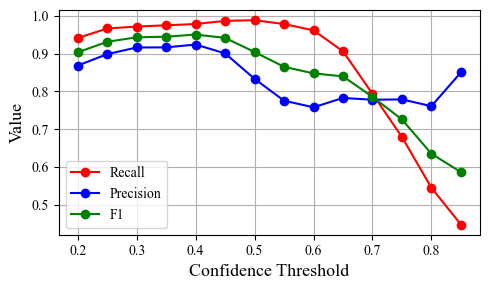

In [113]:
# plot precision recall curve and F1 score curve with different confidence threshold in same canvas, please make it beautiful
plt.figure(figsize=(5,3))
plt.grid()
plt.plot(acc_eva_df['ConfThred'],acc_eva_df['recall'],label = 'Recall', color = 'r', marker = 'o')
plt.plot(acc_eva_df['ConfThred'],acc_eva_df['precision'],label = 'Precision', color = 'b', marker = 'o')
plt.plot(acc_eva_df['ConfThred'],acc_eva_df['F1'],label = 'F1', color = 'g', marker = 'o')
plt.xlabel('Confidence Threshold',fontsize = 13)
plt.ylabel('Value',fontsize = 13)
plt.legend()
plt.tight_layout()
plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\accuracy_evaluation_manual.png',dpi = 300)
plt.show()

In [103]:
# get vehicle number and speed in time_space_diagram_list
dir_img = r'D:\TimeSpaceDiagramDataset\9th&VirTestDiagram_res5\TimeSpace.v7i.yolov8\train\images'
traj_dir = r'D:\TimeSpaceDiagramDataset\9th&VirTestDiagram_res5\TimeSpace.v7i.yolov8\train\labels'
raw_time_space_diagram = np.load(r'D:\TimeSpaceDiagramDataset\9th&VirTestDiagram_res5\lane_2.npy')
img_out_folder = r'D:\TimeSpaceDiagramDataset\9th&VirTestDiagram_res5\TimeSpace.v7i.yolov8\pred_out'
time_span = 100
lane_unit_num = 200
x_error_threshold = 2
time_space_diagram_list = os.listdir(dir_img)
trajectory_list = os.listdir(traj_dir)
vehivle_num_eva = []
speed_eva = []
speed_eva_window = 5
for frame_ind in tqdm(range(len(time_space_diagram_list))):
    time_space_diagram_name = time_space_diagram_list[frame_ind]
    trajectory_name = trajectory_list[frame_ind]
    time_space_diagram_raw = cv2.imread(os.path.join(dir_img,time_space_diagram_name), cv2.IMREAD_GRAYSCALE)
    trajs_label = get_traj_labels(traj_dir,trajectory_name,time_space_diagram_raw)
    vehivle_num_eva.append(len(trajs_label))
    for traj_label in trajs_label:
        if len(trajs_label) < speed_eva_window:
            continue
        t_label, x_label = traj_label[:, 0], traj_label[:, 1]
        # drop duplicate time points
        t_label, indices = np.unique(t_label, return_index=True)
        x_label = x_label[indices]
    
        t_label_max,t_label_min = t_label[-1],t_label[0]
        t_label_interp = np.arange(t_label_min,t_label_max+1)
        
        # Interpolate label trajectory to match pred trajectory time points
        interp_func = interp1d(t_label, x_label, fill_value="extrapolate", kind = 'linear')
        x_label_interp = interp_func(t_label_interp)
        
        for k in range(len(x_label_interp)-speed_eva_window):
            speed_label = -(x_label_interp[k+speed_eva_window] - x_label_interp[k]) * 0.5 / (speed_eva_window/10)
            speed_eva.append(speed_label)
speed_eva = np.array(speed_eva)
speed_eva[speed_eva < 0] = 0

100%|██████████| 109/109 [00:01<00:00, 72.66it/s]


# Sim Dataset

In [5]:
val_dataset = TrajDataset(r"D:\TimeSpaceDiagramDataset\EncoderDecoder_EvenlySampled_FreeflowAug_0914_5res_lanechange_signal\100_frame\val",time_span)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
train_dataset = TrajDataset(r"D:\TimeSpaceDiagramDataset\EncoderDecoder_EvenlySampled_FreeflowAug_0914_5res_lanechange_signal\100_frame\train",time_span)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

In [12]:
vehicle_nums_val = []
vehicle_speed_val = []
batch_count = 0
for batch in tqdm(val_loader):
    post_occ_X = batch['post_occ_X'].to(device)
    target = batch['target'].to(device)
    speed = batch['speed_target'].to(device)
    traj_id = batch['traj_id']
    vehicle_nums_val.append(len(np.unique(traj_id))-1)
    # find mask where target is 1 and speed is not 0 and target is 1 and speed is 0
    mask = (target == 1) & (speed != 0)
    speeds = speed[mask].cpu().numpy()
    vehicle_speed_val.append(speeds)
    if batch_count >  5000:
        break
    batch_count += 1 
    # find the number of elements in mask

  8%|▊         | 5001/61500 [11:12<2:06:39,  7.43it/s]


In [15]:
vehicle_nums_val = np.array(vehicle_nums_val) / batch_size
vehicle_speed_val = np.concatenate(vehicle_speed_val)


In [13]:
vehicle_nums_train = []
vehicle_speed_train = []
batch_count = 0
for batch in tqdm(val_loader):
    post_occ_X = batch['post_occ_X'].to(device)
    target = batch['target'].to(device)
    speed = batch['speed_target'].to(device)
    traj_id = batch['traj_id']
    vehicle_nums_train.append(len(np.unique(traj_id))-1)
    # find mask where target is 1 and speed is not 0 and target is 1 and speed is 0
    mask = (target == 1) & (speed != 0)
    speeds = speed[mask].cpu().numpy()
    vehicle_speed_train.append(speeds)
    if batch_count >  5000:
        break
    batch_count += 1 
    # find the number of elements

  8%|▊         | 5001/61500 [12:46<2:24:18,  6.52it/s]


In [16]:
vehicle_nums_train = np.array(vehicle_nums_train) / batch_size
vehicle_speed_train = np.concatenate(vehicle_speed_train)


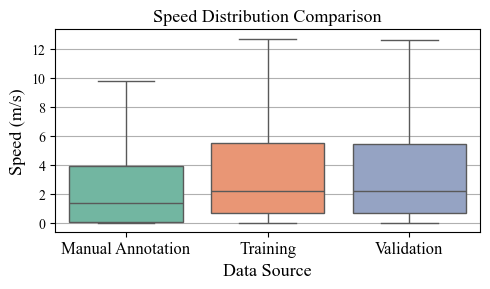

In [104]:

# box plot for speed distribution for vehicle_speed_train, vehicle_speed_val, speed_eva
# make it very bueatiful
plt.figure(figsize=(5,3))
plt.grid(axis = 'y')
sns.boxplot(data = [speed_eva,vehicle_speed_train,vehicle_speed_val],palette = 'Set2',showfliers = False)
plt.xticks([0,1,2],['Manual Annotation','Training','Validation'],fontsize = 12)
plt.ylabel('Speed (m/s)',fontsize = 13)
plt.xlabel('Data Source',fontsize = 13)
plt.title('Speed Distribution Comparison',fontsize = 13)
plt.tight_layout()

plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\dataset_speed_distribution_comparison.png',dpi = 300)
plt.show()

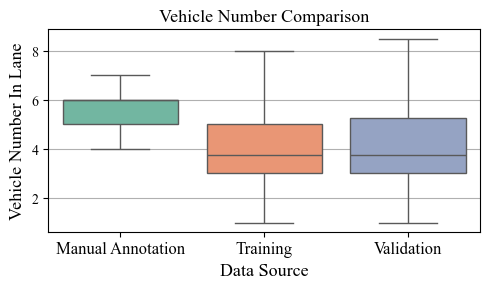

In [102]:

# box plot for speed distribution for vehicle_speed_train, vehicle_speed_val, speed_eva
# make it very bueatiful
plt.figure(figsize=(5,3))
plt.grid(axis = 'y')
sns.boxplot(data = [vehivle_num_eva,vehicle_nums_train,vehicle_nums_val],palette = 'Set2',showfliers = False)
plt.xticks([0,1,2],['Manual Annotation','Training','Validation'],fontsize = 12)
plt.ylabel('Vehicle Number In Lane',fontsize = 13)
plt.xlabel('Data Source',fontsize = 13)
plt.title('Vehicle Number Comparison',fontsize = 13)
plt.tight_layout()
plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\dataset_veh_distribution_comparison.png',dpi = 300)
plt.show()

In [160]:
batch_size = 1
total_tps, total_fps, total_fns = [], [], []
Iou_threshold = 0.8
for conf_thred in np.arange(0.2,0.9,0.05):
    val_dataset = TrajDataset(r"D:\TimeSpaceDiagramDataset\EncoderDecoder_EvenlySampled_FreeflowAug_0914_5res_lanechange_signal\100_frame\val",time_span)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=1)
    count = 0
    total_tp, total_fp, total_fn = 0, 0, 0
    for batch in tqdm(val_loader):
        if count > 5000:
            break
        post_occ_X = batch['post_occ_X'].to(device)
        target = batch['target'].to(device)
        speed = batch['speed_target'].to(device)
        traj_id = batch['traj_id']
        time_space_diagram_input = post_occ_X
        traj_id = traj_id.squeeze(0).cpu().numpy()
        with torch.no_grad():
            input_snippet = time_space_diagram_input
            output = best_model(input_snippet)
            output = output.squeeze(0).cpu().numpy()
        trajs_pred = get_trajs_from_LSTM_out(output,conf_thred = conf_thred,time_span = 100, lane_unit = 200)
        trajs_label = get_trajctories_dict_from_Label_map(traj_id,time_span)
        # convert trajs_label to list
        trajs_label = [trajs_label[i] for i in trajs_label.keys()]
        TrajIoUMatrix,TrajPortionMatrix = get_TrajIoU(trajs_label,trajs_pred,x_error_threshold = x_error_threshold)
        if TrajIoUMatrix.shape[1] == 0:
            # no detection
            total_fn += len(trajs_label)
            continue
        pred_index = TrajPortionMatrix.argmax(axis = 1)
        pred_IoU = []
        for i,j in enumerate(pred_index):
            pred_IoU.append(TrajIoUMatrix[i,j])
        pred_IoU = np.array(pred_IoU)
        # want to figure out the number of true positive trajectories, false positive trajectories, and false negative trajectories
        tp, fp, fn = 0, 0, 0
        for i,j in enumerate(pred_index):
            if pred_IoU[i] >= Iou_threshold:
                tp += 1
            else:
                fn += 1

        for j in trajs_pred.keys():
            if trajs_pred[j][-1][1] > 125:
                continue
            if trajs_pred[j][-1][0] - trajs_pred[j][0][0] < 10:
                continue
            if j not in pred_index:
                fp += 1
        # print(time_space_diagram_name)
        # print(f"TP: {tp}, FP: {fp}, FN: {fn}")
        total_tp += tp
        total_fp += fp
        total_fn += fn
        count += 1
    total_tps.append(total_tp)
    total_fps.append(total_fp)

df = pd.DataFrame({'ConfThred':np.arange(0.2,0.9,0.05),'TP':total_tps,'FP':total_fps,'FN':total_fns})
df['precision'] = df['TP'] / (df['TP'] + df['FP'])
df['recall'] = df['TP'] / (df['TP'] + df['FN'])
df['F1'] = 2 * df['precision'] * df['recall'] / (df['precision'] + df['recall'])
df.to_csv(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\accuracy_evaluation_val.csv',index = False)
    

  0%|          | 90/246000 [00:06<2:21:45, 28.91it/s] c:\Users\zhChe\anaconda3\envs\pygame\lib\site-packages\scipy\interpolate\_interpolate.py:698: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
  0%|          | 197/246000 [00:11<3:52:24, 17.63it/s]


KeyboardInterrupt: 

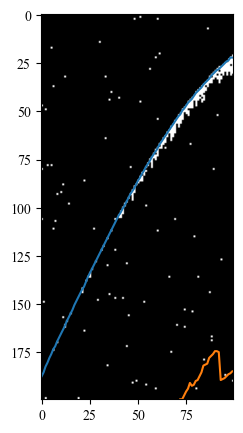

In [158]:
# plot trajs_pred and traj_id(image)
plt.figure(figsize=(10,5))
plt.imshow(time_space_diagram_input.squeeze(0).cpu().numpy(),cmap='gray')
# for traj in trajs_pred.values():
#     t, x = zip(*traj)
#     plt.plot(t,x,label = 'pred')
for traj in trajs_pred.values():
    t, x = zip(*traj)
    plt.plot(t,x,label = 'label')

plt.show()